<a href="https://colab.research.google.com/github/wctseng99/2022-Fintech/blob/main/stock%20price%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [314]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install mpl_finance

(Reading database ... 123968 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [315]:
from talib import abstract
import mpl_finance as mpf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import pickle

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [316]:
# check whether gpu is working
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [317]:
!gdown --id '1ROCh3naEjU_65rwyqxThLlv6U866L5o-' --output APPLE.csv
!gdown --id '1pN6ONp_lUe0NxzwWF3-mxrq8QCnaHBS1' --output APPLE_news.pkl

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ROCh3naEjU_65rwyqxThLlv6U866L5o-
To: /content/APPLE.csv
100% 38.2k/38.2k [00:00<00:00, 25.8MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pN6ONp_lUe0NxzwWF3-mxrq8QCnaHBS1
To: /content/APPLE_news.pkl
100% 27.1M/27.1M [00:00<00:00, 202MB/s]


In [318]:
data = pd.read_csv('/content/APPLE.csv')
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index)
data.index = data.index.format(formatter=lambda x: x.strftime('%Y-%m-%d'))
data.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume', 'Adj Close':'adj close'}, inplace=True)
data

,open,high,low,close,volume,adj close
2011-01-03,120.59,121.63,120.01,121.03,1893100,100.75
2011-01-04,121.78,122.25,119.46,121.86,2816000,101.44
2011-01-05,121.50,125.00,120.37,124.91,3059700,103.98
2011-01-06,125.16,125.59,121.91,122.38,2178000,101.87
2011-01-07,122.80,124.03,122.17,123.17,2035300,102.53
...,...,...,...,...,...,...
2013-12-24,86.10,86.48,85.81,86.21,822100,73.37
2013-12-26,86.50,86.75,85.90,86.31,1232100,73.45
2013-12-27,86.39,87.04,85.88,86.68,1501400,73.77
2013-12-30,87.16,87.83,86.11,86.16,1635100,73.33


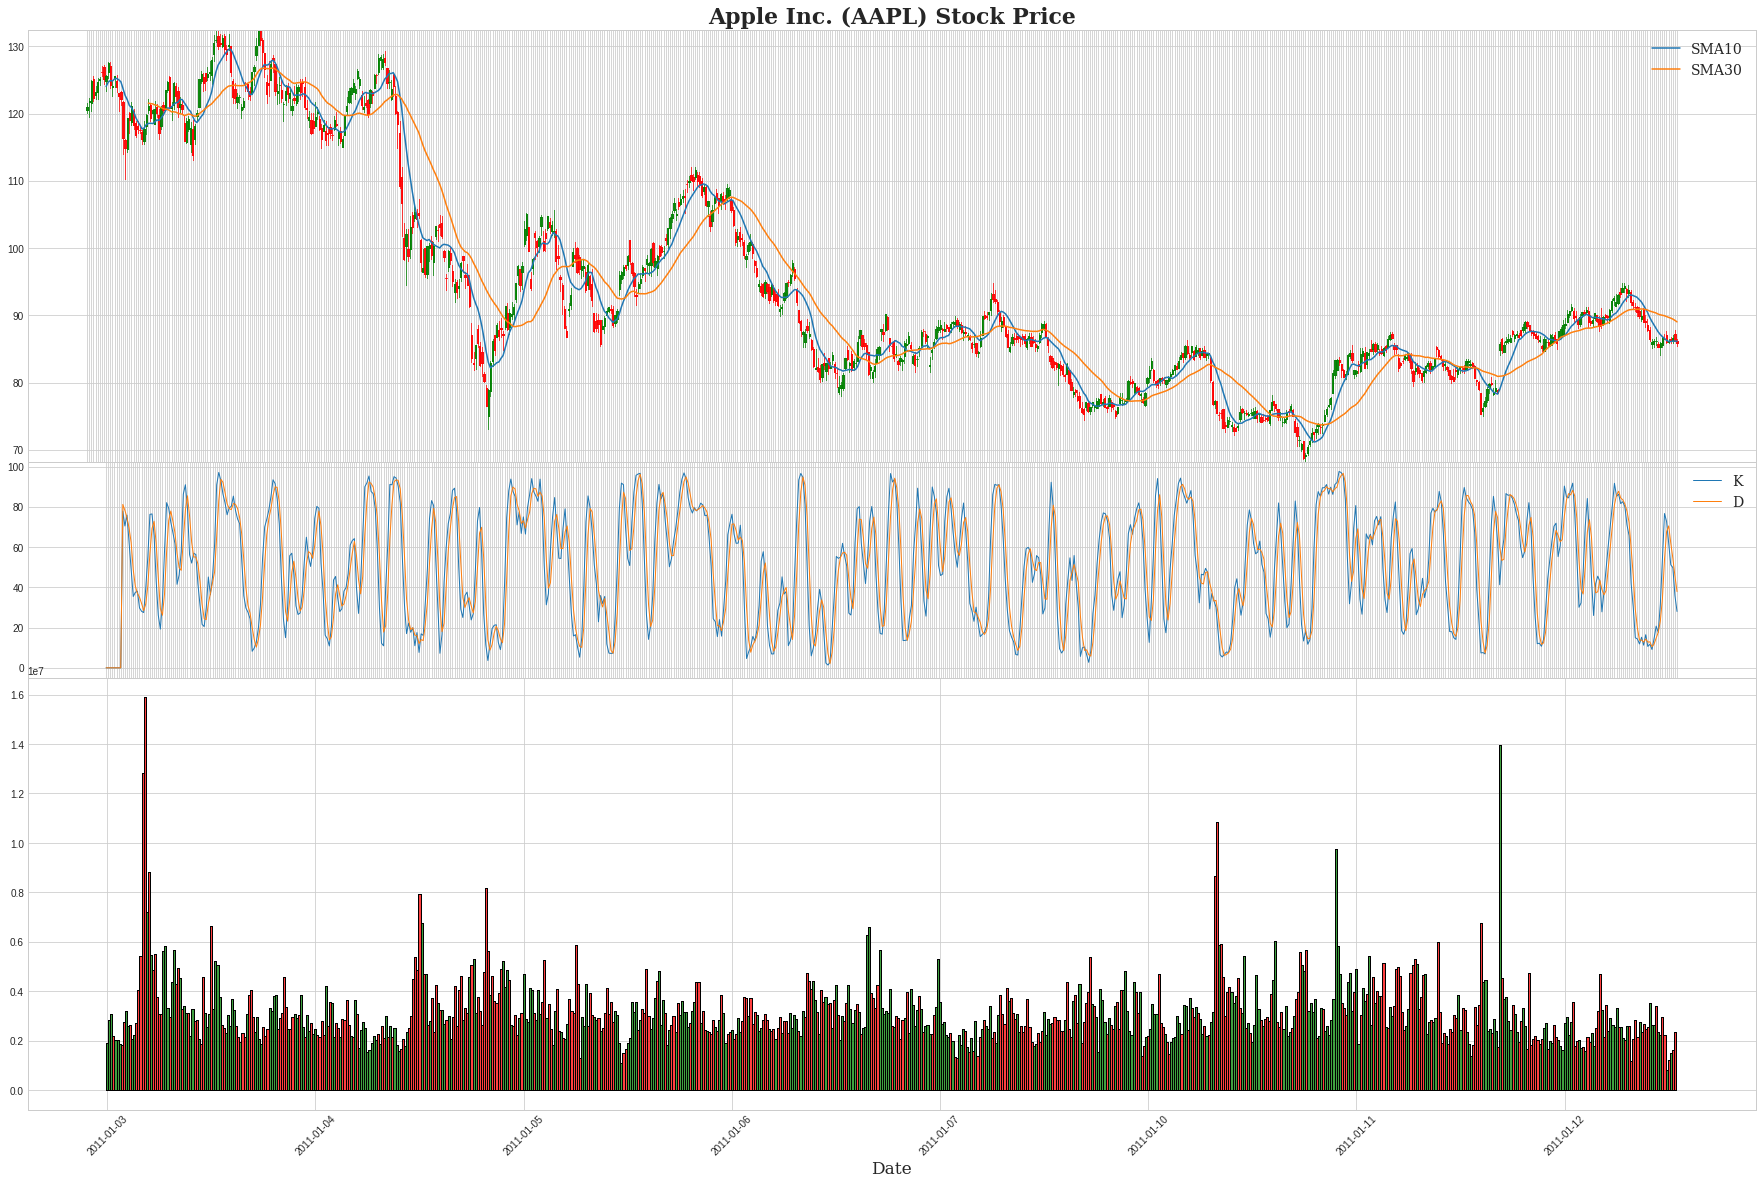

In [319]:

fig = plt.figure(figsize=(24, 15))
ax = fig.add_axes([0, 0.6, 1, 0.4])
ax2 = fig.add_axes([0, 0.4, 1, 0.2])
ax3 = fig.add_axes([0, 0, 1, 0.4])

ax.set_facecolor((1, 1, 1))
ax2.set_facecolor((1, 1, 1))
ax3.set_facecolor((1, 1, 1))
ax3.set_xticks(range(0, len(data.index), 100))
ax3.set_xticklabels(data.index,rotation=45)

plt.xlabel('Date', fontsize=17,  fontfamily='serif')
ax.set_title('Apple Inc. (AAPL) Stock Price', fontsize=22, fontweight='bold', fontfamily='serif')
font = font_manager.FontProperties(family='serif', size=14)

# Candlestick chart with two moving average lines (10 days and 30 days)
mpf.candlestick2_ochl( ax, data['open'], data['close'], data['high'], data['low'],
            width=0.6, colorup='g', colordown='r', alpha=0.75);
#Sample Moving Average
sma_10 = abstract.SMA(data, 10)
sma_30 = abstract.SMA(data, 30) 
data['sma_10'] = sma_10
data['sma_30'] = sma_30        
ax.plot(sma_10, linewidth=1.5, label='SMA10')
ax.plot(sma_30, linewidth=1.5, label='SMA30')
ax.legend(frameon=False, prop=font)

# KD line or Stochastic Oscillator
KD = abstract.STOCH(data)
KD.index=data['close'].index
data['K'] = KD['slowk']
data['D'] = KD['slowd']
data = data.fillna(0)
ax2.plot(data['K'], label='K', linewidth=1)
ax2.plot(data['D'], label='D', linewidth=1)
ax2.legend(frameon=False, prop=font)
            
# Volume bar chart
mpf.volume_overlay(ax3, data['open'], data['close'], data['volume'], colorup='g', colordown='r', width=1, alpha=0.75)

plt.savefig('index.png')


In [320]:
data_close = data['close']
data.drop(['close'], axis=1, inplace=True)
data['close'] = data_close

data

,open,high,low,volume,adj close,sma_10,sma_30,K,D,close
2011-01-03,120.59,121.63,120.01,1893100,100.75,0.000,0.000000,0.000000,0.000000,121.03
2011-01-04,121.78,122.25,119.46,2816000,101.44,0.000,0.000000,0.000000,0.000000,121.86
2011-01-05,121.50,125.00,120.37,3059700,103.98,0.000,0.000000,0.000000,0.000000,124.91
2011-01-06,125.16,125.59,121.91,2178000,101.87,0.000,0.000000,0.000000,0.000000,122.38
2011-01-07,122.80,124.03,122.17,2035300,102.53,0.000,0.000000,0.000000,0.000000,123.17
...,...,...,...,...,...,...,...,...,...,...
2013-12-24,86.10,86.48,85.81,822100,73.37,86.107,89.691000,62.180077,70.507950,86.21
2013-12-26,86.50,86.75,85.90,1232100,73.45,86.096,89.577667,51.188325,62.017372,86.31
2013-12-27,86.39,87.04,85.88,1501400,73.77,86.161,89.438667,49.785226,54.384543,86.68
2013-12-30,87.16,87.83,86.11,1635100,73.33,86.161,89.239667,35.829003,45.600851,86.16


In [321]:
# scaler = MinMaxScaler()
y_min = data['close'].min()
y_max = data['close'].max()

min = data.min()
max = data.max()
data = (data - min) / (max-min)
# data
# data[data.columns] = scaler.fit_transform(data[data.columns])
# data = data.rename_axis('time').reset_index()
# data['time'] = pd.to_datetime(data['time'])
# data.index = pd.to_datetime(data.index)
# data


In [322]:
df_train = data[:'2012-12-31']
df_val = data['2013-01-01':'2013-06-30']
df_test = data['2013-07-01':]

In [323]:
x_train = df_train.drop(columns='close').to_numpy()
x_val = df_val.drop(columns='close').to_numpy()
x_test = df_test.drop(columns='close').to_numpy()

y_train = np.reshape(df_train['close'].to_numpy(), (-1, 1))
y_val = np.reshape(df_val['close'].to_numpy(), (-1, 1))
y_test = np.reshape(df_test['close'].to_numpy(), (-1, 1))


In [324]:
class SequenceDataset(Dataset):
    def __init__(self, feature, label, sequence_length):
        self.sequence_length = sequence_length
        self.X = torch.tensor(feature).float()
        self.y = torch.tensor(label).float()
        # print(int(np.ceil(self.X.shape[0]/self.sequence_length)))
        
    def __len__(self):

        return int(np.ceil(self.X.shape[0]/self.sequence_length))

    def __getitem__(self, i): 
        
        x = self.X[i*self.sequence_length:(i+1)*self.sequence_length]
        y = self.y[i*self.sequence_length:(i+1)*self.sequence_length]

        return x, y

In [325]:
i = 0
sequence_length = 30

train_dataset = SequenceDataset(
    feature = x_train,
    label = y_train,
    sequence_length=sequence_length
)

val_dataset= SequenceDataset(
    feature = x_val,
    label = y_val,
    sequence_length=sequence_length
)

test_dataset= SequenceDataset(
    feature = x_test,
    label = y_test,
    sequence_length=sequence_length
)

In [326]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [327]:
class RNN(nn.Module):
    def __init__(self, input_size=9, num_layers=1, hidden_size=64, output_size=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size= hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [328]:
class LSTM(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=64, num_layers=1, output_dim=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, output_dim) 
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() 
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # out = self.fc(out[:, -1, :]) # out[:, -1, :] --> just want last time step hidden states
        out = self.fc(out)
        out = self.fc2(out)
        return out


In [329]:
class GRU(nn.Module):
    def __init__(self, input_size=9, hidden_size=64, num_layers=1, output_size=1):
        super().__init__()
        self.hidden_size  = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)       
        out,_ = self.gru(x, h0)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
        

In [330]:
learning_rate = 0.001
model = LSTM()
# model = GRU()
# model = RNN()
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
print(model)

LSTM(
  (lstm): LSTM(9, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


In [331]:
def train_model(data_loader, model, loss_function, optimizer):
    total_loss = []

    model.train()
    for X, y in data_loader:
        optimizer.zero_grad()
        output = model(X)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())

    avg_loss = np.mean(total_loss)
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    total_loss = []

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss.append(loss_function(output, y).item())
    avg_loss = np.mean(total_loss)
    print(f"Val loss: {avg_loss}")
    return avg_loss

loss_history = {}  # loss history
loss_history['train'] = []
loss_history['val'] = []

print("Untrained test\n--------")
best_loss=test_model(val_loader, model, loss_fn)
print()
for epoch in range(150):
    print(f"---------\nEpoch: {epoch}")
    train_loss=train_model(train_loader, model, loss_fn, optimizer)
    val_loss=test_model(val_loader, model, loss_fn)

    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)    
    stat = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }

    if val_loss < best_loss:
      best_loss = val_loss
      torch.save(stat, '/content/best-model-parameters.pt')
      print("save best epoch")

Untrained test
--------
Val loss: 0.023090855637565254

---------
Epoch: 0
Train loss: 0.18350930517429814
Val loss: 0.060589845106005666
---------
Epoch: 1
Train loss: 0.05167842300280052
Val loss: 0.03548363670706749
---------
Epoch: 2
Train loss: 0.04278103622388752
Val loss: 0.02911360077559948
---------
Epoch: 3
Train loss: 0.025587962036404538
Val loss: 0.008709237538278103
save best epoch
---------
Epoch: 4
Train loss: 0.012866713021032731
Val loss: 0.0025694088079035284
save best epoch
---------
Epoch: 5
Train loss: 0.01080081142101656
Val loss: 0.006363555230200291
---------
Epoch: 6
Train loss: 0.009366784814868452
Val loss: 0.004687218461185694
---------
Epoch: 7
Train loss: 0.010653755696052137
Val loss: 0.002518174913711846
save best epoch
---------
Epoch: 8
Train loss: 0.0051833566189195745
Val loss: 0.0024861406534910204
save best epoch
---------
Epoch: 9
Train loss: 0.008324055747567293
Val loss: 0.005246052145957946
---------
Epoch: 10
Train loss: 0.004374926988555885


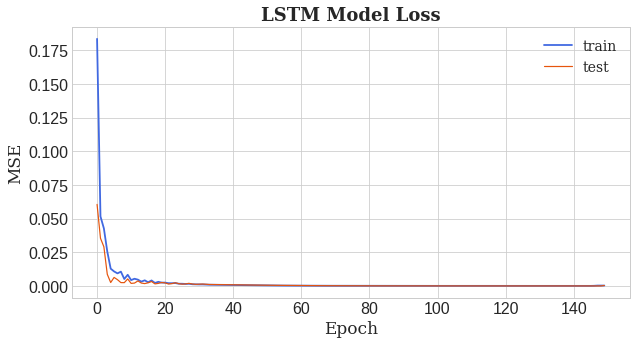

In [332]:
# summarize history for loss
fig, ax = plt.subplots(1,1,figsize=(10, 5),)
x = np.arange(0,150,1)

plt.plot(x,loss_history['train'], label='train', color='royalblue', linewidth=1.8)
plt.plot(x,loss_history['val'], label='test', color='#e6550d', linewidth=1.2)
plt.title('LSTM Model Loss',fontsize=18, fontweight='bold', fontfamily='serif')
plt.ylabel('MSE', fontsize=17,  fontfamily='serif')
plt.xlabel('Epoch', fontsize=17,  fontfamily='serif')
font = font_manager.FontProperties(family='serif', size=14)
plt.legend(frameon=False, prop=font)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.style.use('seaborn-whitegrid')
plt.savefig("train&val_MSEloss.png", facecolor='w')
plt.show()

In [333]:
def predict_model(data_loader, model):
    
    output = []
    model.eval()
    with torch.no_grad():
      for X, _ in data_loader:
          y_pred = model(X)
          y_pred = y_pred.numpy().flatten().tolist()
          output.extend(y_pred)
    return output

In [334]:
model.load_state_dict(torch.load('/content/best-model-parameters.pt')['state_dict'])
# test_shape=predict_model(test_loader, best_model).numpy().shape
# print(test_shape)
prediction = predict_model(test_loader, model)
predicted_y = []
real_y = []
for i in range(len(prediction)):
  predicted_y.append(prediction[i] * (max['close']-min['close']) + min['close']) # to get the original scale
  real_y.append(y_test.flatten()[i]* (max['close']-min['close']) + min['close'])
predicted_y=pd.DataFrame({'prediction': predicted_y, 'real': real_y})
predicted_y['Time'] = df_test.index
predicted_y=predicted_y.set_index('Time')
predicted_y

,prediction,real
Time,,
2013-07-01,83.839041,83.30
2013-07-02,82.526196,82.13
2013-07-03,80.355241,80.23
2013-07-05,82.378190,82.17
2013-07-08,82.019124,81.45
...,...,...
2013-12-24,85.790067,86.21
2013-12-26,85.993161,86.31
2013-12-27,86.443611,86.68


In [335]:
from sklearn.metrics import mean_squared_error
MSE_y=mean_squared_error(predicted_y['real'], predicted_y['prediction'])
print('MSE: ',MSE_y)

errorIndex=pd.DataFrame({'MSE':MSE_y}, index=[0])
print(errorIndex)
errorIndex.to_csv('PredictError.csv', float_format='%.4f') 

MSE:  0.12718826052779791
        MSE
0  0.127188


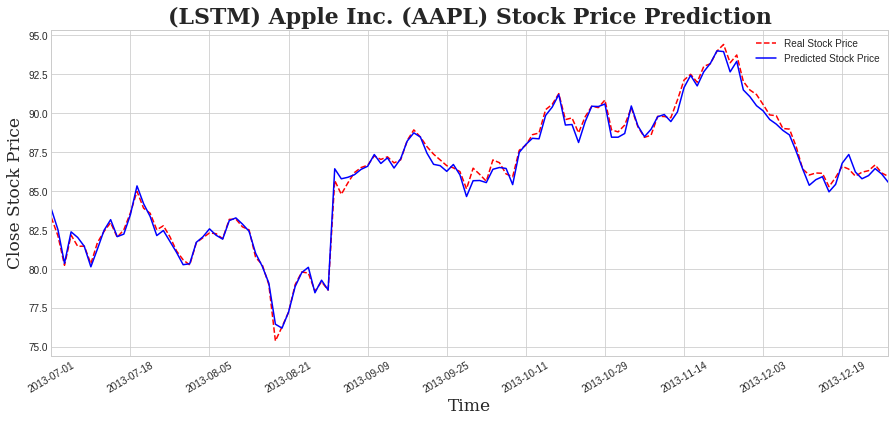

In [336]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
# axes.xaxis_date()

axes.plot(predicted_y.index, predicted_y['real'], 'r--', label = 'Real Stock Price')
axes.plot(predicted_y.index, predicted_y['prediction'], 'b', label = 'Predicted Stock Price')

axes.set_title('(LSTM) Apple Inc. (AAPL) Stock Price Prediction', fontsize=22, fontweight='bold', fontfamily='serif')
plt.xlabel('Time', fontsize=17,  fontfamily='serif')
plt.ylabel('Close Stock Price', fontsize=17,  fontfamily='serif')

xticks = axes.get_xticks()
axes.set_xticks(xticks[::len(xticks) // 10]) # set new tick positions
axes.tick_params(axis='x', rotation=30) # set tick rotation
axes.margins(x=0) # set tight margins
# axes.get_figure().autofmt_xdate()

font = font_manager.FontProperties(family='serif', size=14)
plt.legend()
plt.style.use('seaborn-whitegrid')
plt.savefig('price_pred.png')

plt.show()